In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from google.colab import drive

# Google Driveのマウント
drive.mount('/content/drive', force_remount=True)

# TSVファイルの読み込み
master_path = "/content/drive/MyDrive/train_master.tsv"
gemini_path = "/content/drive/MyDrive/gemini.tsv"
Multinomial_path = "/content/drive/MyDrive/MultinomialNB.tsv"
bert_path = "/content/drive/MyDrive/bert.tsv"

master = pd.read_csv(master_path, sep="\t")
gemini = pd.read_csv(gemini_path, sep="\t")
Multinomial = pd.read_csv(Multinomial_path, sep="\t")
bert = pd.read_csv(bert_path, sep="\t")

# ラベルを数値型に変換（geminiの'skip'を2として処理）
gemini['label'] = gemini['label'].replace('skip', 2).astype(int)
Multinomial['label'] = Multinomial['label'].astype(int)
bert['label'] = bert['label'].astype(int)
master['label'] = master['label'].astype(int)

# アンサンブルラベルの作成（多数決）
# geminiのラベルが2（分類不能）である行を無視
ensemble_labels = []
for idx in range(len(bert)):  # Change to iterate over length of Perceptron
    labels = [Multinomial.loc[idx, 'label'], bert.loc[idx, 'label']]
    if gemini.loc[idx, 'label'] != 2:  # geminiが有効なラベルの場合
        labels.append(gemini.loc[idx, 'label'])
    # 多数決でラベルを決定
    majority_label = max(set(labels), key=labels.count)
    ensemble_labels.append(majority_label)

# 正解ラベルと予測ラベルを準備
y_true = master['label'][:len(bert)]  # 実際のラベル - adjust y_true to match y_pred length
y_pred = pd.Series(ensemble_labels)

# 正解ラベルが入ったデータフレーム
correct_labels = master[['label']]  # master DataFrameから'label'カラムを抽出

# 条件に該当するカウント
gem_correct_count = 0
gem_incorrect_count = 0
mul_correct_count = 0
mul_incorrect_count = 0
per_correct_count = 0
per_incorrect_count = 0

# geminiの正解と不正解の数をカウント
total_count = len(bert)  # 全体のデータ数

for idx in range(total_count):
    # 各モデルのラベル
    labels = [Multinomial.loc[idx, 'label'], bert.loc[idx, 'label']]
    if gemini.loc[idx, 'label'] != 2:
        labels.append(gemini.loc[idx, 'label'])

    # 多数決
    majority_label = max(set(labels), key=labels.count)

    # gemini が多数決結果かつ正解である場合をチェック
    if majority_label == gemini.loc[idx, 'label'] and majority_label == correct_labels.loc[idx, 'label']:
        gem_correct_count += 1

    # gemini が多数決結果かつ不正解である場合をチェック
    if majority_label == gemini.loc[idx, 'label'] and majority_label != correct_labels.loc[idx, 'label']:
        gem_incorrect_count += 1

    # Multinomial が多数決結果かつ正解である場合をチェック
    if majority_label == Multinomial.loc[idx, 'label'] and majority_label == correct_labels.loc[idx, 'label']:
        mul_correct_count += 1

    # Multinomial が多数決結果かつ不正解である場合をチェック
    if majority_label == Multinomial.loc[idx, 'label'] and majority_label != correct_labels.loc[idx, 'label']:
        mul_incorrect_count += 1

    # Perceptron が多数決結果かつ正解である場合をチェック
    if majority_label == bert.loc[idx, 'label'] and majority_label == correct_labels.loc[idx, 'label']:
        per_correct_count += 1

    # Perceptron が多数決結果かつ不正解である場合をチェック
    if majority_label == bert.loc[idx, 'label'] and majority_label != correct_labels.loc[idx, 'label']:
        per_incorrect_count += 1

# 割合を計算
print(f"データ数: {total_count}")
gem_correct_ratio = gem_correct_count / total_count
print(f"geminiが採用されかつ正解だった割合: {gem_correct_ratio:.2%} データ数: {gem_correct_count}")
gem_incorrect_ratio = gem_incorrect_count / total_count
print(f"geminiが採用されかつ不正解だった割合: {gem_incorrect_ratio:.2%} データ数: {gem_incorrect_count}")
mul_correct_ratio = mul_correct_count / total_count
print(f"Multinomialが採用されかつ正解だった割合: {mul_correct_ratio:.2%} データ数: {mul_correct_count}")
mul_incorrect_ratio = mul_incorrect_count / total_count
print(f"Multinomialが採用されかつ不正解だった割合: {mul_incorrect_ratio:.2%} データ数: {mul_incorrect_count}")
per_correct_ratio = per_correct_count / total_count
print(f"Bertが採用されかつ正解だった割合: {per_correct_ratio:.2%} データ数: {per_correct_count}")
per_incorrect_ratio = per_incorrect_count / total_count
print(f"Bertが採用されかつ不正解だった割合: {per_incorrect_ratio:.2%} データ数: {per_incorrect_count}")

# 評価指標の計算
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 結果の出力
print(f"正解率 (Accuracy): {accuracy:.2f}")
print(f"適合率 (Precision): {precision:.2f}")
print(f"再現率 (Recall): {recall:.2f}")
print(f"F値 (F1-score): {f1:.2f}")
print("\n分類レポート:")
print(classification_report(y_true, y_pred, target_names=["スパム", "正常"]))


Mounted at /content/drive
データ数: 2000
geminiが採用されかつ正解だった割合: 89.95% データ数: 1799
geminiが採用されかつ不正解だった割合: 1.30% データ数: 26
Multinomialが採用されかつ正解だった割合: 94.85% データ数: 1897
Multinomialが採用されかつ不正解だった割合: 1.25% データ数: 25
Bertが採用されかつ正解だった割合: 95.00% データ数: 1900
Bertが採用されかつ不正解だった割合: 1.40% データ数: 28
正解率 (Accuracy): 0.98
適合率 (Precision): 0.97
再現率 (Recall): 0.97
F値 (F1-score): 0.97

分類レポート:
              precision    recall  f1-score   support

         スパム       0.99      0.99      0.99      1421
          正常       0.97      0.97      0.97       579

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



Mounted at /content/drive
正解率 (Accuracy): 0.95
適合率 (Precision): 0.90
再現率 (Recall): 0.93
F値 (F1-score): 0.91

分類レポート:
              precision    recall  f1-score   support

        spam       0.97      0.96      0.96      1416
    not spam       0.90      0.93      0.91       576

    accuracy                           0.95      1992
   macro avg       0.94      0.94      0.94      1992
weighted avg       0.95      0.95      0.95      1992



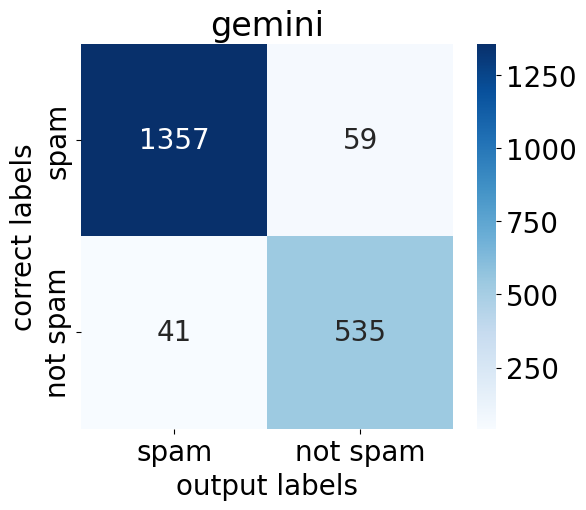

In [ ]:
# 必要なライブラリをインポート
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# ファイルパス（ColabでのGoogle Driveマウントを想定）
gemini_path = "/content/drive/MyDrive/comparison_results_prompt.tsv"
master_path = "/content/drive/MyDrive/train_master.tsv"

# ファイルを読み込む
gemini = pd.read_csv(gemini_path, sep="\t")
master = pd.read_csv(master_path, sep="\t")

# NaNを含む行を削除
gemini_filtered = gemini.dropna(subset=['extract_label']).copy()

# 'skip' を除外し、ラベルを整数型に変換
gemini_filtered = gemini_filtered[gemini_filtered['extract_label'] != 'skip']
gemini_filtered['extract_label'] = gemini_filtered['extract_label'].astype(int)
gemini_filtered['master_label'] = gemini_filtered['master_label'].astype(int)

# masterデータのラベルを整数型に変換
master['label'] = master['label'].astype(int)

# `file_name` 列と `filename` 列をキーとしてデータを結合
merged_df = gemini_filtered.merge(master, left_on="filename", right_on="file_name")

# 正解ラベルと予測ラベルを取得
y_true = merged_df['label']  # 正解ラベル（masterデータ）
y_pred = merged_df['extract_label']  # Geminiモデルの予測ラベル

# 評価指標の計算
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 結果の出力
print(f"正解率 (Accuracy): {accuracy:.2f}")
print(f"適合率 (Precision): {precision:.2f}")
print(f"再現率 (Recall): {recall:.2f}")
print(f"F値 (F1-score): {f1:.2f}")
print("\n分類レポート:")
print(classification_report(y_true, y_pred, target_names=["spam", "not spam"]))

# 混同行列の計算
cm = confusion_matrix(y_true, y_pred)

plt.rcParams.update({'font.size': 20})  # デフォルトフォントサイズを変更

# ヒートマップを作成
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["spam", "not spam"], yticklabels=["spam", "not spam"])
plt.xlabel("output labels")
plt.ylabel("correct labels")
plt.title("gemini")
plt.show()


Mounted at /content/drive
正解率 (Accuracy): 0.95
適合率 (Precision): 0.91
再現率 (Recall): 0.94
F値 (F1-score): 0.92

分類レポート:
              precision    recall  f1-score   support

         スパム       0.97      0.96      0.97      1421
          正常       0.91      0.94      0.92       579

    accuracy                           0.95      2000
   macro avg       0.94      0.95      0.95      2000
weighted avg       0.96      0.95      0.95      2000



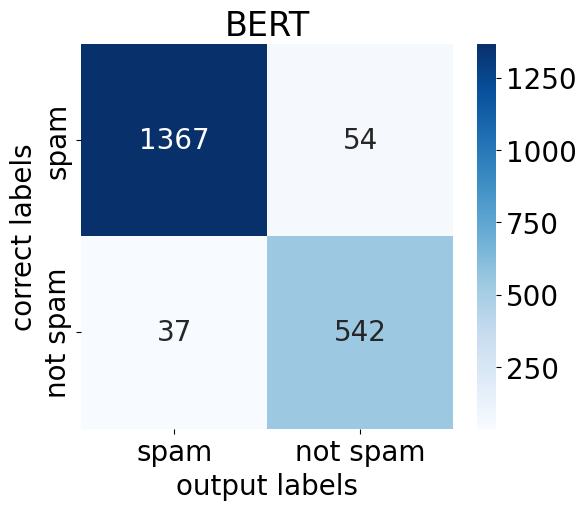

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from google.colab import drive

# Google Driveのマウント
drive.mount('/content/drive', force_remount=True)

bert_path = "/content/drive/MyDrive/bert.tsv"

bert = pd.read_csv(bert_path, sep="\t")

bert = bert['label'].astype(int)

# 正解ラベルと予測ラベルを準備
y_true = master['label'][:len(bert)]  # 実際のラベル - adjust y_true to match y_pred length
y_pred = pd.Series(bert)

# 評価指標の計算
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 結果の出力
print(f"正解率 (Accuracy): {accuracy:.2f}")
print(f"適合率 (Precision): {precision:.2f}")
print(f"再現率 (Recall): {recall:.2f}")
print(f"F値 (F1-score): {f1:.2f}")
print("\n分類レポート:")
print(classification_report(y_true, y_pred, target_names=["スパム", "正常"]))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 混同行列の計算
cm = confusion_matrix(y_true, y_pred)

# ヒートマップを作成
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["spam", "not spam"], yticklabels=["spam", "not spam"])
plt.xlabel("output labels")
plt.ylabel("correct labels")
plt.title("BERT")
plt.show()

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from google.colab import drive

# Google Driveのマウント
drive.mount('/content/drive', force_remount=True)

# TSVファイルの読み込み
master_path = "/content/drive/MyDrive/train_master.tsv"
gemini_path = "/content/drive/MyDrive/prompt.tsv"
Multinomial_path = "/content/drive/MyDrive/MultinomialNB.tsv"
bert_path = "/content/drive/MyDrive/bert.tsv"

master = pd.read_csv(master_path, sep="\t")
gemini = pd.read_csv(gemini_path, sep="\t")
Multinomial = pd.read_csv(Multinomial_path, sep="\t")
bert = pd.read_csv(bert_path, sep="\t")

# ラベルを数値型に変換（geminiの'skip'を2として処理）
gemini['label'] = gemini['label'].replace('skip', 2).astype(int)
Multinomial['label'] = Multinomial['label'].astype(int)
bert['label'] = bert['label'].astype(int)
master['label'] = master['label'].astype(int)

# アンサンブルラベルの作成（多数決）
# geminiのラベルが2（分類不能）である行を無視
ensemble_labels = []
for idx in range(len(bert)):  # Change to iterate over length of Perceptron
    labels = [Multinomial.loc[idx, 'label'], bert.loc[idx, 'label']]
    if gemini.loc[idx, 'label'] != 2:  # geminiが有効なラベルの場合
        labels.append(gemini.loc[idx, 'label'])
    # 多数決でラベルを決定
    majority_label = max(set(labels), key=labels.count)
    ensemble_labels.append(majority_label)

# 正解ラベルと予測ラベルを準備
y_true = master['label'][:len(bert)]  # 実際のラベル - adjust y_true to match y_pred length
y_pred = pd.Series(ensemble_labels)

# 正解ラベルが入ったデータフレーム
correct_labels = master[['label']]  # master DataFrameから'label'カラムを抽出

# 条件に該当するカウント
gem_correct_count = 0
gem_incorrect_count = 0
mul_correct_count = 0
mul_incorrect_count = 0
per_correct_count = 0
per_incorrect_count = 0

# geminiの正解と不正解の数をカウント
total_count = len(bert)  # 全体のデータ数

for idx in range(total_count):
    # 各モデルのラベル
    labels = [Multinomial.loc[idx, 'label'], bert.loc[idx, 'label']]
    if gemini.loc[idx, 'label'] != 2:
        labels.append(gemini.loc[idx, 'label'])

    # 多数決
    majority_label = max(set(labels), key=labels.count)

    # gemini が多数決結果かつ正解である場合をチェック
    if majority_label == gemini.loc[idx, 'label'] and majority_label == correct_labels.loc[idx, 'label']:
        gem_correct_count += 1

    # gemini が多数決結果かつ不正解である場合をチェック
    if majority_label == gemini.loc[idx, 'label'] and majority_label != correct_labels.loc[idx, 'label']:
        gem_incorrect_count += 1

    # Multinomial が多数決結果かつ正解である場合をチェック
    if majority_label == Multinomial.loc[idx, 'label'] and majority_label == correct_labels.loc[idx, 'label']:
        mul_correct_count += 1

    # Multinomial が多数決結果かつ不正解である場合をチェック
    if majority_label == Multinomial.loc[idx, 'label'] and majority_label != correct_labels.loc[idx, 'label']:
        mul_incorrect_count += 1

    # Perceptron が多数決結果かつ正解である場合をチェック
    if majority_label == bert.loc[idx, 'label'] and majority_label == correct_labels.loc[idx, 'label']:
        per_correct_count += 1

    # Perceptron が多数決結果かつ不正解である場合をチェック
    if majority_label == bert.loc[idx, 'label'] and majority_label != correct_labels.loc[idx, 'label']:
        per_incorrect_count += 1

# 割合を計算
print(f"データ数: {total_count}")
gem_correct_ratio = gem_correct_count / total_count
print(f"geminiが採用されかつ正解だった割合: {gem_correct_ratio:.2%} データ数: {gem_correct_count}")
gem_incorrect_ratio = gem_incorrect_count / total_count
print(f"geminiが採用されかつ不正解だった割合: {gem_incorrect_ratio:.2%} データ数: {gem_incorrect_count}")
mul_correct_ratio = mul_correct_count / total_count
print(f"Multinomialが採用されかつ正解だった割合: {mul_correct_ratio:.2%} データ数: {mul_correct_count}")
mul_incorrect_ratio = mul_incorrect_count / total_count
print(f"Multinomialが採用されかつ不正解だった割合: {mul_incorrect_ratio:.2%} データ数: {mul_incorrect_count}")
per_correct_ratio = per_correct_count / total_count
print(f"Bertが採用されかつ正解だった割合: {per_correct_ratio:.2%} データ数: {per_correct_count}")
per_incorrect_ratio = per_incorrect_count / total_count
print(f"Bertが採用されかつ不正解だった割合: {per_incorrect_ratio:.2%} データ数: {per_incorrect_count}")

# 評価指標の計算
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 結果の出力
print(f"正解率 (Accuracy): {accuracy:.2f}")
print(f"適合率 (Precision): {precision:.2f}")
print(f"再現率 (Recall): {recall:.2f}")
print(f"F値 (F1-score): {f1:.2f}")
print("\n分類レポート:")
print(classification_report(y_true, y_pred, target_names=["スパム", "正常"]))

Mounted at /content/drive
データ数: 2000
geminiが採用されかつ正解だった割合: 94.00% データ数: 1880
geminiが採用されかつ不正解だった割合: 1.35% データ数: 27
Multinomialが採用されかつ正解だった割合: 95.05% データ数: 1901
Multinomialが採用されかつ不正解だった割合: 1.55% データ数: 31
Bertが採用されかつ正解だった割合: 94.70% データ数: 1894
Bertが採用されかつ不正解だった割合: 1.20% データ数: 24
正解率 (Accuracy): 0.98
適合率 (Precision): 0.97
再現率 (Recall): 0.96
F値 (F1-score): 0.97

分類レポート:
              precision    recall  f1-score   support

         スパム       0.98      0.99      0.99      1421
          正常       0.97      0.96      0.97       579

    accuracy                           0.98      2000
   macro avg       0.98      0.97      0.98      2000
weighted avg       0.98      0.98      0.98      2000



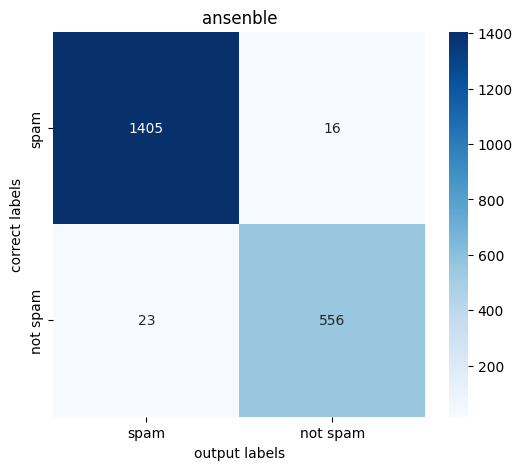

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 混同行列の計算
cm = confusion_matrix(y_true, y_pred)

# ヒートマップを作成
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["spam", "not spam"], yticklabels=["spam", "not spam"])
plt.xlabel("output labels")
plt.ylabel("correct labels")
plt.title("ansenble")
plt.show()